In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import blackjack as bj
from blackjack import Hand, HandScore, Action, make_hand

In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False, drawn=False)

In [10]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False, drawn=True)

In [11]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False, drawn=True)

In [12]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False, drawn=True), True)

In [13]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False, drawn=True)

In [14]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=s12, cards=[1, 1], doubled=False, drawn=True)

In [15]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h12, cards=[1, 1, 11], doubled=False, drawn=True)

In [16]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False, drawn=True), True)

## Now define gameplay and strategy

In [17]:
[bj.deal_card() for _ in range(10)]

[6, 10, 2, 2, 8, 6, 5, 1, 6, 11]

In [18]:
bj.play_one_round([bj.strat_nobust, bj.strat_nobust])

[('strat_nobust',
  Hand(score=h15, cards=[5, 12], doubled=False, drawn=True),
  Hand(score=h22, cards=[13, 3, 11], doubled=False, drawn=True),
  <HandOutcome.WIN: 1>),
 ('strat_nobust',
  Hand(score=h15, cards=[5, 12], doubled=False, drawn=True),
  Hand(score=h22, cards=[13, 3, 11], doubled=False, drawn=True),
  <HandOutcome.WIN: 1>)]

## Aggregate and summarize the data from the simulations

In [19]:

def generate_row_from_player(player):
    (strat, hand_p, hand_d, outcome) = player
    return {'strategy': strat, 'hand_start': hand_p.cards[:2], 'dealer_card': hand_d.cards[0], 'hand_end': hand_p.cards, 'dealer_hand': hand_d.cards, 'outcome': outcome}

def generate_rows_from_round(r):
    return [generate_row_from_player(player) for player in r]

strat_nobust = bj.strat_nobust
strat_dealer = bj.strat_dealer
generate_rows_from_round(bj.play_one_round([bj.strat_nobust, bj.strat_dealer]))


[{'strategy': 'strat_nobust',
  'hand_start': [9, 13],
  'dealer_card': 2,
  'hand_end': [9, 13],
  'dealer_hand': [2, 13, 10],
  'outcome': <HandOutcome.WIN: 1>},
 {'strategy': 'strat_dealer',
  'hand_start': [9, 13],
  'dealer_card': 2,
  'hand_end': [9, 13],
  'dealer_hand': [2, 13, 10],
  'outcome': <HandOutcome.WIN: 1>}]

In [20]:
def run_n_sim_trials(strats, n):
    sims = [generate_rows_from_round(bj.play_one_round(strats)) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

def summarize_totals(sims):
    def outcome_name(x): return x.head(1) # The function name will be used as the column name
    outcome_counts = sims.groupby(['strategy', 'outcome_value'])['outcome_name'].agg([len, outcome_name])
    outcome_summary = outcome_counts.reset_index().set_index('strategy').drop(['outcome_value'], axis=1).pivot(columns=['outcome_name'])

    # The empty cells are NaNs; fill the NaNs and convert back to int
    for col in outcome_summary.columns:
        outcome_summary[col] = outcome_summary[col].fillna(0).apply(int)
        
    outcome_summary['mean_outcome'] = sims.groupby('strategy')['outcome_value'].mean()
    
    return outcome_summary


sim_results = run_n_sim_trials([strat_nobust, strat_dealer], 100000)
%prun -s cumulative sim_results, summarize_totals(sim_results)

In [21]:
def strat_simple(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple.name = 'simple'


sims = run_n_sim_trials([strat_simple], 1000)
sims.head(10), summarize_totals(sims)

(  strategy hand_start  dealer_card    hand_end    dealer_hand  \
 0   simple    [9, 12]            3     [9, 12]     [3, 13, 5]   
 1   simple    [9, 10]            1     [9, 10]  [1, 5, 11, 2]   
 2   simple    [7, 11]            7     [7, 11]      [7, 5, 7]   
 3   simple     [2, 3]            3  [2, 3, 12]      [3, 5, 9]   
 4   simple    [12, 2]           10  [12, 2, 5]        [10, 8]   
 5   simple     [3, 3]            6   [3, 3, 7]      [6, 9, 3]   
 6   simple     [3, 3]            6  [3, 3, 10]      [6, 6, 8]   
 7   simple    [13, 4]            3     [13, 4]     [3, 5, 11]   
 8   simple     [4, 1]            5      [4, 1]     [5, 9, 10]   
 9   simple   [12, 13]            5    [12, 13]  [5, 6, 5, 11]   
 
             outcome  outcome_value outcome_name  
 0   HandOutcome.WIN            1.0          WIN  
 1   HandOutcome.WIN            1.0          WIN  
 2  HandOutcome.LOSE           -1.0         LOSE  
 3  HandOutcome.LOSE           -1.0         LOSE  
 4  HandOutcome.L

In [22]:
%prun -s cumulative summarize_totals(run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


## Simulate specific situations to determine strategy

In [23]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False, drawn=True),
 Hand(score=h02, cards=[2], doubled=False, drawn=True))

In [24]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]

def generate_strat_conditional(strat_base, conditions):
    def strat_cond(score_p, score_d):
        for (condition, action) in conditions:
            if condition(score_p, score_d): return action
        return strat_base(score_p, score_d)
    strat_cond.name = 'strat_cond'
    return strat_cond
    
strat_cond = generate_strat_conditional(strat_simple, conditions)

In [25]:
def gen_cond_strategies(strat_base, condition, actions):
    def gen_strat_action(strat_base, condition, action):
        strat = generate_strat_conditional(strat_base, [(condition, action)])
        strat.name = repr(action)
        return strat
    
    strats = [gen_strat_action(strat_base, condition, a) for a in actions]
    return strats
    



strats = gen_cond_strategies(strat_simple, cond_12_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [26]:
bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())

[('<Action.HIT: 2>',
  Hand(score=h22, cards=[5, 7, 11], doubled=False, drawn=True),
  Hand(score=h21, cards=[2, 4, 5, 13], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('<Action.STAND: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False, drawn=True),
  Hand(score=h21, cards=[2, 4, 5, 13], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('<Action.DOUBLE: 3>',
  Hand(score=h18, cards=[5, 7, 6], doubled=False, drawn=True),
  Hand(score=h21, cards=[2, 4, 5, 13], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>)]

In [27]:
# TODO reduce duplication with run_n_sim_trials
def run_n_sim_trials_from_state(strats, hand_p, hand_d, n):
    sims = [generate_rows_from_round(bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

sims = run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
summarize_totals(sims)

len            mean_outcome
outcome_name        LOSE PUSH   WIN             
strategy                                        
<Action.DOUBLE: 3>  6035  667  3298      -0.2737
<Action.HIT: 2>     6027  621  3352      -0.2675
<Action.STAND: 1>   6316    0  3684      -0.2632

In [28]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=s12, cards=[1, 1], doubled=False, drawn=True),
 Hand(score=h02, cards=[2], doubled=False, drawn=True))

In [29]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = gen_cond_strategies(strat_simple, cond_12s_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [30]:
sims = run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
summarize_totals(sims)

len            mean_outcome
outcome_name        LOSE PUSH   WIN             
strategy                                        
<Action.DOUBLE: 3>  5288  818  3894      -0.1394
<Action.HIT: 2>     5304  822  3874      -0.1430
<Action.STAND: 1>   6413    0  3587      -0.2826
simple              5227  825  3948      -0.1279

In [31]:
summarize_totals(run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 10*1000))

len            mean_outcome
outcome_name  LOSE PUSH   WIN             
strategy                                  
simple        6051  636  3313      -0.2738
strat_cond    6389    0  3611      -0.2778

In [32]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = gen_cond_strategies(strat_simple, cond_13s_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 10000)
summarize_totals(sims)

len            mean_outcome
outcome_name        LOSE PUSH   WIN             
strategy                                        
<Action.DOUBLE: 3>  4847  307  4846      -0.0001
<Action.HIT: 2>     4836  328  4836       0.0000
<Action.STAND: 1>   5779    0  4221      -0.1558
simple              5779    0  4221      -0.1558

In [33]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = gen_cond_strategies(strat_simple, cond_10_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
summarize_totals(sims)

len            mean_outcome
outcome_name        LOSE PUSH   WIN             
strategy                                        
<Action.DOUBLE: 3>  3194  688  6118       0.2924
<Action.HIT: 2>     3185  697  6118       0.2933
<Action.STAND: 1>   5757    0  4243      -0.1514
simple              3214  685  6101       0.2887

In [34]:
ACTIONS = [Action.HIT, Action.STAND, Action.DOUBLE]

def test_cond(score_p, score_d, n, strat_base = strat_simple):
    def cond(p, d):
        return p == score_p and d == score_d
    strats = gen_cond_strategies(strat_base, cond, ACTIONS)
    hand_p = Hand(score_p) 
    hand_d = make_hand([score_d.points if score_d.points< 11 else 1])
    sims = run_n_sim_trials_from_state(strats, hand_p, hand_d, n)
    return cond, summarize_totals(sims)

test_cond(HandScore(10), HandScore(6), 10000, strat_simple)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                      len                                   mean_outcome
 outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
 strategy                                                               
 <Action.DOUBLE: 3>     0        3215  730     0       6055       0.5680
 <Action.HIT: 2>     3186           0  678  6136          0       0.2950
 <Action.STAND: 1>   5811           0    0  4189          0      -0.1622)

In [35]:
test_cond(HandScore(18), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         166    1    0         33       -1.330
 <Action.HIT: 2>     160           0    3   37          0       -0.615
 <Action.STAND: 1>    64           0   21  115          0        0.255)

In [36]:
test_cond(HandScore(21, True), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0          65   13    0        122        0.570
 <Action.HIT: 2>      67           0   17  116          0        0.245
 <Action.STAND: 1>     0           0   19  181          0        0.905)

In [37]:
def find_winning_action(score_p, score_d, n, strat_base = strat_simple):
    cond, summary = test_cond(score_p, score_d, n, strat_base)
    outcomes = summary['mean_outcome']
    # Find the winning strategy
    winner = outcomes[outcomes==outcomes.max()].index[0]
    winning_act = [a for a in ACTIONS if repr(a)==winner][0]

    # Convert results to a dict
    output = outcomes.to_dict()
    output['score_p'] = repr(score_p)
    output['score_d'] = repr(score_d)
    output['winning_act'] = winning_act
    output['winning_act_outcome'] = outcomes.max()

    return output

find_winning_action(HandScore(10), HandScore(6), 200)

{'<Action.DOUBLE: 3>': 0.7,
 '<Action.HIT: 2>': 0.32,
 '<Action.STAND: 1>': -0.04,
 'score_p': 'h10',
 'score_d': 'h06',
 'winning_act': <Action.DOUBLE: 3>,
 'winning_act_outcome': 0.7}

In [38]:
test_cond(HandScore(18), HandScore(11, True), 1000)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         862   24    0        114       -1.496
 <Action.HIT: 2>     868           0   22  110          0       -0.758
 <Action.STAND: 1>   605           0  121  274          0       -0.331)

In [39]:
def compute_instructions(n, strat_base = strat_simple):
    return [find_winning_action(p, make_hand([d]).score, n, strat_base) for p in all_scores for d in range(1, 11) if p.points>=9]

In [40]:
%prun -s cumulative conds = compute_instructions(10)
pd.DataFrame(conds).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h09     s11                    -1.4            -0.70               -1.0   
        h02                     0.4             0.20               -0.2   
        h03                    -0.2             0.00               -0.2   
        h04                     0.0            -0.10               -0.8   
        h05                     0.4             0.40                0.2   
...                             ...              ...                ...   
s21     h06                     0.6             0.00                0.8   
        h07                     0.8             0.55                0.9   
        h08                     0.8            -0.20                0.9   
        h09                     0.4             0.20                1.0   
        h10                    -0.4            -0.50                1.0   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h09     s11         Action.HIT                 -0.7  
        h02      Action.DOUBLE                  0.4  
        h03         Action.HIT                  0.0  
        h04      Action.DOUBLE                  0.0  
        h05      Action.DOUBLE                  0.4  
...                        ...                  ...  
s21     h06       Action.STAND                  0.8  
        h07       Action.STAND                  0.9  
        h08       Action.STAND                  0.9  
        h09       Action.STAND                  1.0  
        h10       Action.STAND                  1.0  

[250 rows x 5 columns]

In [41]:
def run_iteration(n, strat_base, previous_instructions):
    comput = compute_instructions(n, strat_base)
    outputs = pd.DataFrame(comput).set_index(['score_p', 'score_d'])
    
    instructions = {(output['score_p'], output['score_d']): output['winning_act'] for output in comput}
    
    fig = plt.figure()
    # Visualize the winning action by starting condition
    sns.heatmap(outputs['winning_act'].apply(lambda x: x.value).unstack(), ax=fig.add_subplot(1, 2, 1))
    
    # Visualize the average outcome by starting condition
    sns.heatmap(outputs['winning_act_outcome'].unstack(), ax=fig.add_subplot(1, 2, 2))
    
    if previous_instructions:
        for k in instructions:
            if instructions[k] != previous_instructions[k]:
                print(k, instructions[k], previous_instructions[k])
    
    return instructions
        

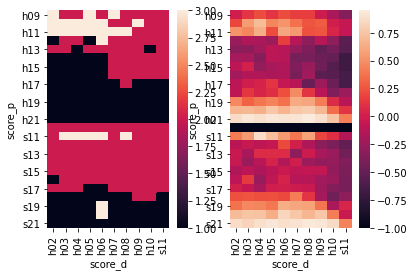

In [42]:
%prun -s cumulative run_iteration(100, strat_simple, None)

In [43]:
# Memoized strategy
# Rather than generic conditions, just use an array indexed on player and dealer scores
# Since that's how we're generating our strategy anyway (one square at a time)

def gen_strat_memoized(instructions, strat_base):
    def strat_memoized(score_p, score_d):
        k = (repr(score_p), repr(score_d))
        if k in instructions:
            return instructions[k]
        else:
            return strat_base(score_p, score_d)
    strat_memoized.name = 'memoized'
    return strat_memoized

instructions = {(repr(HandScore(13, True)), repr(HandScore(6))): Action.HIT}
strat_memoized = gen_strat_memoized(instructions, strat_simple)

sims = run_n_sim_trials([strat_simple, strat_memoized], 1000)
sims.head(10), summarize_totals(sims)

(   strategy hand_start  dealer_card         hand_end   dealer_hand  \
 0    simple    [1, 11]            5          [1, 11]    [5, 11, 7]   
 1  memoized    [1, 11]            5          [1, 11]    [5, 11, 7]   
 2    simple     [2, 6]           13       [2, 6, 12]       [13, 7]   
 3  memoized     [2, 6]           13  [2, 6, 5, 3, 2]       [13, 7]   
 4    simple     [3, 9]            7       [3, 9, 13]  [7, 8, 1, 1]   
 5  memoized     [3, 9]            7        [3, 9, 5]  [7, 8, 1, 1]   
 6    simple     [8, 7]            1        [8, 7, 5]       [1, 11]   
 7  memoized     [8, 7]            1       [8, 7, 10]       [1, 11]   
 8    simple    [10, 1]           10          [10, 1]      [10, 12]   
 9  memoized    [10, 1]           10          [10, 1]      [10, 12]   
 
                  outcome  outcome_value outcome_name  
 0  HandOutcome.BLACKJACK            1.5    BLACKJACK  
 1  HandOutcome.BLACKJACK            1.5    BLACKJACK  
 2        HandOutcome.WIN            1.0         

0
1
('h09', 'h02') Action.DOUBLE Action.HIT
('h09', 'h03') Action.DOUBLE Action.HIT
('h09', 'h05') Action.HIT Action.DOUBLE
('h09', 'h06') Action.DOUBLE Action.HIT
('h09', 'h10') Action.HIT Action.DOUBLE
('h10', 'h02') Action.DOUBLE Action.HIT
('h10', 'h07') Action.DOUBLE Action.HIT
('h10', 'h08') Action.HIT Action.DOUBLE
('h10', 'h09') Action.DOUBLE Action.HIT
('h11', 'h02') Action.DOUBLE Action.HIT
('h11', 'h07') Action.HIT Action.DOUBLE
('h11', 'h08') Action.DOUBLE Action.HIT
('h11', 'h10') Action.DOUBLE Action.HIT
('h12', 'h03') Action.HIT Action.STAND
('h12', 'h10') Action.HIT Action.DOUBLE
('h13', 'h02') Action.DOUBLE Action.HIT
('h13', 'h05') Action.STAND Action.HIT
('h13', 'h09') Action.HIT Action.STAND
('h14', 'h02') Action.HIT Action.STAND
('h14', 'h06') Action.STAND Action.HIT
('h14', 'h10') Action.HIT Action.STAND
('h15', 'h02') Action.STAND Action.HIT
('h15', 'h06') Action.STAND Action.HIT
('h15', 'h09') Action.HIT Action.STAND
('h16', 'h08') Action.HIT Action.STAND
('s11'

[<function __main__.strat_simple(score_p, score_d)>,
 <function __main__.gen_strat_memoized.<locals>.strat_memoized(score_p, score_d)>,
 <function __main__.gen_strat_memoized.<locals>.strat_memoized(score_p, score_d)>,
 <function __main__.gen_strat_memoized.<locals>.strat_memoized(score_p, score_d)>,
 <function __main__.gen_strat_memoized.<locals>.strat_memoized(score_p, score_d)>,
 <function __main__.gen_strat_memoized.<locals>.strat_memoized(score_p, score_d)>]

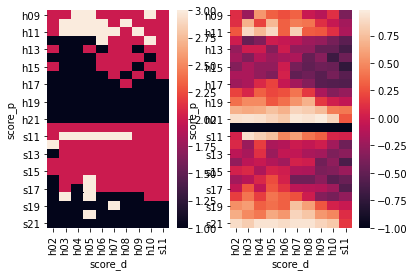

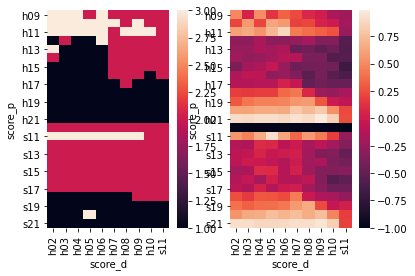

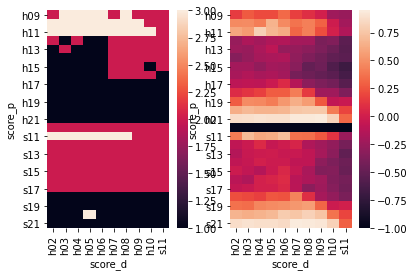

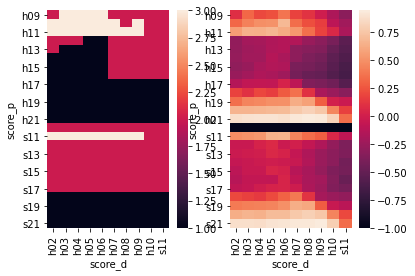

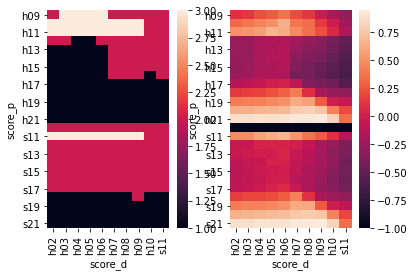

In [44]:
n = 50
strat_base = strat_simple
previous_instructions = None
strategies = [strat_simple]

for i in range(5):
    print(i)
    instructions = run_iteration(n, strat_base, previous_instructions)
    strat_new  = gen_strat_memoized(instructions, strat_base)
    strat_new.name = f'iter({i+1})'
    strategies.append(strat_new)
    previous_instructions = instructions
    strat_base = strat_new
    n = n*3

strategies

In [45]:
sims = run_n_sim_trials(strategies, 300*1000)
sims.head(10), summarize_totals(sims)

(  strategy hand_start  dealer_card            hand_end  dealer_hand  \
 0   simple     [4, 1]            4              [4, 1]   [4, 5, 11]   
 1  iter(1)     [4, 1]            4           [4, 1, 7]   [4, 5, 11]   
 2  iter(2)     [4, 1]            4          [4, 1, 12]   [4, 5, 11]   
 3  iter(3)     [4, 1]            4  [4, 1, 2, 2, 2, 7]   [4, 5, 11]   
 4  iter(4)     [4, 1]            4          [4, 1, 11]   [4, 5, 11]   
 5  iter(5)     [4, 1]            4           [4, 1, 9]   [4, 5, 11]   
 6   simple     [1, 8]           13              [1, 8]  [13, 2, 10]   
 7  iter(1)     [1, 8]           13              [1, 8]  [13, 2, 10]   
 8  iter(2)     [1, 8]           13              [1, 8]  [13, 2, 10]   
 9  iter(3)     [1, 8]           13              [1, 8]  [13, 2, 10]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.LOSE           -1.0         LOSE  
 2  HandOutcome.LOSE           -1.0         LOSE  
 3